# Training a model

Below is the example for a simple Gaussian Process classification example using GpyTorch :class:`.VariationalGaussianProcessClassifier`

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from torch.autograd import Variable

from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import VariationalGaussianProcessClassifier

torch.manual_seed(7)
# Grid points are [0,1] every 1/9
train_x = Variable(torch.linspace(0, 1, 10))
# Labels are unit wave with period 1/2 centered with positive values @ x=0
train_y = Variable(torch.sign(torch.cos(train_x.data * (4 * math.pi))))

In [2]:
# Step 1: Define the GP model
# Basic classification model with variational inference
class GPClassificationModel(gpytorch.models.VariationalGP):
    def __init__(self, train_inputs):
        super(GPClassificationModel, self).__init__(train_inputs)
        # Only non-zero mean function can be learned
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        # Use universal approximator RBF kernel
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5, 6))

    def forward(self, x):
        # Get predictive mean and covariance
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Scale covariance
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Package prediction as GaussianRandomVariable
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        # Return predictions
        return latent_pred

In [3]:
# Step 2: Wrap the model into our GP Wrapper
GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
)

# Step 3: Find optimal model hyperparameters
GPWrapper.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Test x are regularly spaced by 0.01 0,1 inclusive
test_x = Variable(torch.linspace(0, 1, 101))
observed_pred = GPWrapper.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1      325.9557  0.0862
      2      228.1859  0.0134
      3      147.3188  0.0173
      4       94.1946  0.0132
      5       57.9264  0.0128
      6       33.7167  0.0110
      7       20.0186  0.0236
      8       14.3599  0.0122
      9       12.4063  0.0153
     10       11.9052  0.0213
     11       11.1336  0.0129
     12        9.9352  0.0137
     13        9.7594  0.0138
     14        9.2419  0.0108
     15        7.5268  0.0132
     16        6.7588  0.0129
     17        6.4355  0.0107
     18        5.7118  0.0139
     19        5.5610  0.0133
     20        5.1346  0.0131
     21        5.1171  0.0115
     22        5.4638  0.0164
     23        4.9524  0.0205
     24        5.1271  0.0222
     25        5.4291  0.0230
     26        4.9319  0.0123
     27        4.8011  0.0172
     28        4.9526  0.0175
     29        4.6320  0.0134
     30        5.0012  0.0119
     31        5.1621  0.0162
     32   

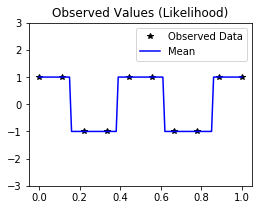

In [4]:
# (*) Step 5: Plotting
# Initialize fig and axes for plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# Plotting function
# A lot of this should be consolidated as helper between different notebooks
def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot square wave predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GPWrapper),
])

pipe.fit(X=train_x.unsqueeze(-1), y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1      189.6633  0.0162
      2      115.8089  0.0162
      3       60.4891  0.0145
      4       28.6950  0.0122
      5       12.6096  0.0120
      6        6.3260  0.0127
      7        4.7166  0.0127
      8        4.9294  0.0121
      9        4.8688  0.0126
     10        4.3113  0.0105
     11        4.3976  0.0111
     12        4.0188  0.0156
     13        4.3445  0.0134
     14        4.1298  0.0130
     15        4.5064  0.0120
     16        4.3699  0.0116
     17        4.8133  0.0124
     18        4.5483  0.0112
     19        4.9878  0.0101
     20        5.3043  0.0126
     21        5.3614  0.0168
     22        5.2772  0.0139
     23        5.4562  0.0141
     24        5.6869  0.0119
     25        5.6429  0.0138
     26        5.6271  0.0136
     27        5.8642  0.0138
     28        5.2855  0.0097
     29        5.1485  0.0108
     30        5.3748  0.0095
     31        5.1599  0.0143
     32   

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.VariationalGaussianProcessClassifier'>[initialized](
  module_=GPClassificationModel(
    (mean_module): ConstantMean()
    (covar_module): RBFKernel()
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
)

gs = GridSearchCV(GPWrapper, params, refit=False, cv=3, scoring='accuracy', 
                  return_train_score=False)  #  Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1      269.5632  0.0104
      2      259.7476  0.0184
      3      249.9569  0.0121
      4      240.5389  0.0104
      5      231.6512  0.0084
      6      222.8682  0.0086
      7      214.3439  0.0100
      8      206.0892  0.0079
      9      198.2059  0.0096
     10      190.5099  0.0093
  epoch    train_loss     dur
-------  ------------  ------
      1      258.7633  0.0082
      2      248.7378  0.0095
      3      238.8357  0.0090
      4      229.3974  0.0116
      5      220.1867  0.0101
      6      211.1628  0.0088
      7      202.7144  0.0108
      8      194.7346  0.0106
      9      186.6107  0.0104
     10      179.1036  0.0108
  epoch    train_loss     dur
-------  ------------  ------
      1      290.1546  0.0069
      2      279.5425  0.0112
      3      269.0094  0.0098
      4      258.9151  0.0087
      5      249.2876  0.0112
      6      240.2287  0.0103
      7      231.0015  0.0083
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`